# Fundamentals of Neural Signal Processing

*Data is like garbage. You'd better know what you are going to do with it once you collect it. - Mark Twain*  

<br>

This is the **first** in a series of hands-on tutorials designed to teach neural data analysis. No programming background is necessary, but a familiarity with basic Python, linear algebra, and electrophysiology is helpful. The tutorial is implemented in a Google Colab notebook, so no local Python installation is required; see the `README.md` file for setup instructions.

### Objectives:
1. Understand the difference between time and frequency representations of data
2. Outline preprocessing steps, their reasons for use, and specific pros/cons
3. Describe what a *Fourier transform* does and why they are used
4. **DIY**: investigate MTL theta activity using basic spectral analyses

----
> Justin Campbell   
> justin.campbell@hsc.utah.edu  
> Version: 07-10-23

## Setup Notebook
Run this cell to install/import the libraries and packages used throughout.

In [1]:
# Install MNE
! pip install MNE

import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import YouTubeVideo
from mne.time_frequency import tfr_multitaper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 46.9 MB/s eta 0:00:00


## 0. Pre-Work

### 0.1 Intro to Google Colab
This brief video provides an overview of how to interact with `.ipynb` documents via Google Colab.

In [ ]:
YouTubeVideo('inN8seMm7UI', width = 600, height = 400)

Key Points:
- Google Colab is a web-based code platform that requires no setup and is free to use
- Because it is structured like other Google Docs, it is easy to share with others, leave comments, and auto-save changes
- To run code cells, simply hit the *play* button (or *shift+enter*)

### 0.2 Preprocessing Steps
This video by Mike X Cohen reviews the differences between preprocessing and postprocessing and provides an overview of the common preprocessing steps most often used in neural data analysis.

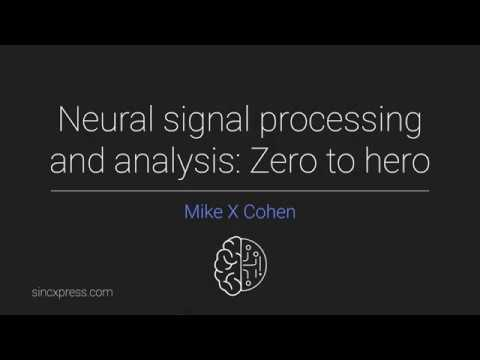

In [5]:
YouTubeVideo('JMB9nZNGVyk', width = 600, height = 400)

Key Points:
- We *preprocess* neural data before *processing* to facilitate analysis and clean up the signals
- There are many different preprocessing steps, each with a different intended use
- Common steps include: *rejecting bad data*, *rereferencing*, *filtering*, and *downsampling*

### 0.3 Time and Frequency Domains
These videos by Mike X Cohen describe how time-series data can be represented in both the time and frequency domains, and provides a walk through of how to interpret the common forms of visualization (e.g., power spectra, spectrograms).

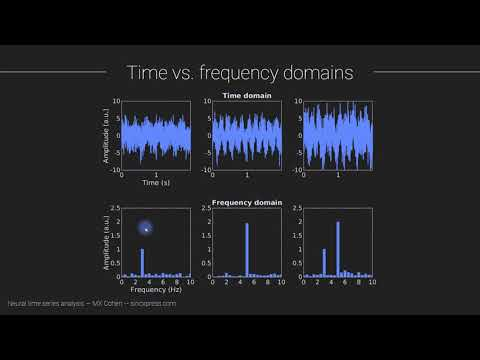

In [6]:
YouTubeVideo('fYtVHhk3xJ0', width = 600, height = 400)

Key Points:
- Neural signals can be separately analyzed in the time- and frequency-domains
- Each domain has pros/cons and reveals different properties of the underlying signals

### 0.4 The Fourier Transform
This video by 3B1B provides a high-level, intuitive understanding for the *Fourier Transform*, a fundamental concept in time-frequency analyses.

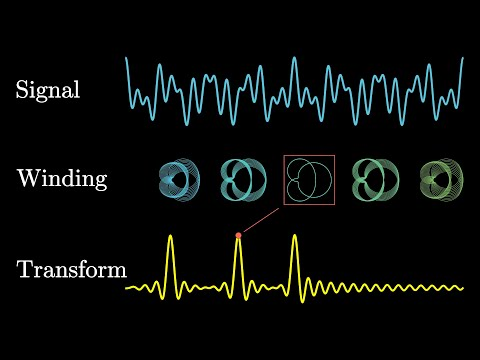

In [8]:
YouTubeVideo('spUNpyF58BY', width = 600, height = 400)

Key Points:
- The *Fourier Transform* is a mathematical function that describes the power of each frequency in an underlying signal

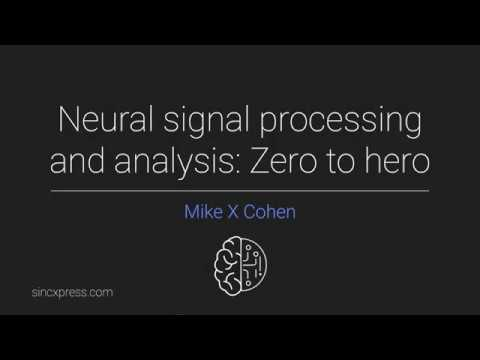

In [7]:
YouTubeVideo('s2MfmIx8wv4', width = 600, height = 400)

Key Points:
- Data is represented differently in the time- and frequency-domains
- *Static* time-frequency analyses average across time
- *Dynamic* time-frequency analyses include time as a variable

## 1. Time-Domain Representations

### 1.1 Simulated Oscillations
Working with artificial/simulated data is a great way for developing an intutive understanding of how to work with neural signals. Here we create an oscillation using the following formula:


$$y = A \sin(2\pi ft + \phi)$$

Where,  
$A$ = amplitude  
$f$ = frequency  
$t$ = time  
$\phi$ = phase  

Below, we create a sinusoidal oscillation by defining each of these parameters.  
 **Try changing each parameter separately to see how the oscillation is affected**.

In [ ]:
# Oscillation parameters
osc_freq = 5 # frequency (Hz)
osc_amp = 2 # amplitude (arbitrary units)
osc_phs = 0 # phase offset (radians)
osc_fs = 200 # sampling rate (Hz)
osc_dur = 1 # duration (sec)

# Create vector for times
t = np.arange(0, osc_dur, 1/osc_fs)

# Create sine wave
sim_osc = osc_amp * np.sin(2 * np.pi * osc_freq * t + osc_phs) # Amplitude * (2* pi * Frequency * Time + Phase)

# Visualize
plt.figure(figsize = (12,4))
plt.plot(t, sim_osc)

To get a sense for how each parameter of the sine wave can vary independently, let's create a 2x2 subplot where we separately change the amplitude, frequency, phase, and sampling rate.

In [ ]:
# Oscillation parameters
osc_freq = 5 # frequency (Hz)
osc_amp = 2 # amplitude (arbitrary units)
osc_phs = 0 # phase offset (radians)
osc_fs = 200 # sampling rate (Hz)
osc_dur = 1 # duration (sec)

# Create vector for times
t = np.arange(0, osc_dur, 1/osc_fs)

# Create 2x2 subplots
fig, axes = plt.subplots(2,2, figsize = (12,8))

# Add base oscillation to all subplots
for i in [0,1]:
  for ii in [0,1]:
    axes[i,ii].plot(t,sim_osc, linewidth = 3)

# Change individual parameters
axes[0,0].plot(t, (osc_amp * 4) * np.sin(2 * np.pi * osc_freq * t + osc_phs), color = 'r',)
axes[0,1].plot(t, osc_amp * np.sin(2 * np.pi * (osc_freq*2) * t + osc_phs), color = 'r')
axes[1,0].plot(t, osc_amp * np.sin(2 * np.pi * osc_freq * t + (osc_phs + 2)), color = 'r')
axes[1,1].plot(np.arange(0, osc_dur, 1/(osc_fs / 15)), osc_amp * np.sin(2 * np.pi * osc_freq * np.arange(0, osc_dur, 1/(osc_fs / 15)) + osc_phs), color = 'r')

# Add titles
axes[0,0].set_title('Change in Amplitude')
axes[0,1].set_title('Change in Frequency')
axes[1,0].set_title('Change in Phase')
axes[1,1].set_title('Change in Sampling Rate')

### 1.2 Load the SEEG Dataset
For the rest of the tutorial, we'll be using a sample dataset provided by `MNE`. This dataset was collected from one neurosurgical patient who underwent stereoelectroencephalography (SEEG) monitoring. This procedure involves placement of several intracranial macroelectrodes, from which the neural signals are recorded.

Here, we create a `MNE.io.Raw()` data object, which has a lot of built in functionality as you'll see below. You can find more details about this data structure in their documentation [here](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw).

In [2]:
data_path = mne.datasets.misc.data_path()
raw = mne.io.read_raw(data_path / "seeg" / "sample_seeg_ieeg.fif")
raw.load_data()

Using default location ~/mne_data for misc...
Creating ~/mne_data
Dataset misc version 0.0 out of date, latest version is 0.26


0.00B [00:00, ?B/s]
Untarring contents of '/root/mne_data/mne-misc-data-0.26.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 45s (278.8 MB)
Opening raw data file /root/mne_data/MNE-misc-data/seeg/sample_seeg_ieeg.fif...
    Range : 1310640 ... 1370605 =   1311.411 ...  1371.411 secs
Ready.
Reading 0 ... 59965  =      0.000 ...    60.000 secs...


<Raw | sample_seeg_ieeg.fif, 119 x 59966 (60.0 s), ~54.6 MB, data loaded>

By printing out the data, we can get a sense for its overall structure (channel x time).

In [4]:
pd.DataFrame(raw.get_data())

,0,1,2,3,4,5,6,7,8,9,...,59956,59957,59958,59959,59960,59961,59962,59963,59964,59965
0,0.008045,0.008045,0.008054,0.008052,0.008046,0.008043,0.008042,0.008054,0.008051,0.008047,...,0.008109,0.008105,0.008098,0.008106,0.008120,0.008113,0.008105,0.008094,0.008088,0.008095
1,-0.006884,-0.006882,-0.006876,-0.006876,-0.006878,-0.006883,-0.006880,-0.006863,-0.006869,-0.006874,...,-0.006836,-0.006838,-0.006847,-0.006841,-0.006830,-0.006833,-0.006842,-0.006851,-0.006856,-0.006852
2,0.001835,0.001840,0.001848,0.001853,0.001852,0.001857,0.001862,0.001881,0.001883,0.001881,...,0.001992,0.001992,0.001982,0.001988,0.002001,0.001992,0.001985,0.001973,0.001966,0.001971
3,-0.003436,-0.003430,-0.003425,-0.003421,-0.003424,-0.003424,-0.003424,-0.003410,-0.003411,-0.003415,...,-0.003549,-0.003553,-0.003562,-0.003556,-0.003546,-0.003548,-0.003556,-0.003566,-0.003570,-0.003565
4,-0.002759,-0.002757,-0.002752,-0.002747,-0.002748,-0.002751,-0.002747,-0.002732,-0.002735,-0.002741,...,-0.002956,-0.002964,-0.002973,-0.002970,-0.002958,-0.002962,-0.002972,-0.002980,-0.002984,-0.002981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.003679,0.003689,0.003702,0.003704,0.003705,0.003704,0.003705,0.003721,0.003717,0.003710,...,0.003652,0.003644,0.003636,0.003641,0.003651,0.003640,0.003634,0.003619,0.003619,0.003623
115,0.001948,0.001957,0.001967,0.001968,0.001961,0.001962,0.001963,0.001980,0.001973,0.001970,...,0.001900,0.001894,0.001884,0.001888,0.001895,0.001887,0.001880,0.001865,0.001862,0.001865
116,-0.006027,-0.006019,-0.006009,-0.006007,-0.006012,-0.006009,-0.006009,-0.005990,-0.005995,-0.006003,...,-0.006051,-0.006058,-0.006068,-0.006063,-0.006053,-0.006062,-0.006071,-0.006079,-0.006081,-0.006076
117,-0.006343,-0.006336,-0.006333,-0.006335,-0.006339,-0.006347,-0.006341,-0.006329,-0.006333,-0.006341,...,-0.006374,-0.006380,-0.006389,-0.006384,-0.006376,-0.006387,-0.006398,-0.006406,-0.006406,-0.006401


Let's create variables to store some meaningful information:
- `chans`: channel labels
- `fs`: sampling frequency (Hz)
- `times`: vector representing sample number (converted to sec)
- `data`: raw data (channels x samples)

In [ ]:
chans = raw.ch_names
fs = raw.info['sfreq']
times = raw.times
data = raw.get_data()

print('There are %i channels in the dataset' %len(chans))
print('The sampling rate is %.2f Hz' %fs)
print('The duration of the recording is %.2f seconds' %max(times))

### 1.3 Visualize Raw Time-Series Data
Let's start by just visualizing our raw time-series data. Since this dataset is large (100+ channels), we'll focus our attention on specific channels of interest.

In [ ]:
chans # print out a list of all channel labels

To find the position of a specific label in the list we created, we can use the method `.index()`. This returns the index (i.e., position) of whatever particular channel label we provide. We can then use that index to find only the specific data we are interested in. Of note, **Python uses 0-indexing**, meaning that the 1st item in a list as at index 0, the 2nd item in the list is at index 1, etc.

In [ ]:
chan_idx = chans.index('LAMY 1')
print('The channel index is: %i' %chan_idx)

In [ ]:
# Visualize raw channel data
plt.plot(data[chan_idx,:])

There's a lot that we could do to improve this figure. The x- and y-axes aren't intuitive, and they are also unlabeled. Additionally, by plotting the data from the entire recording session, we overlook some of the finer-grained temporal specificity we are interested in. Let's clean it up a bit by adding axis labels and cropping the plot to just the first 3 seconds of the recording.

In [ ]:
# Add times to change x-axis to sec, multiply data x 1000 to convert y-axis to mV
plt.plot(times, data[chan_idx,:] * 1000)

# Crop the time to display
start_time = 0
end_time = 3

# Clean-up figure appearance
plt.xlim([start_time, end_time])
plt.xlabel('Time (sec)', fontsize = 'large')
plt.ylabel('Amplitude (mV)', fontsize = 'large')
plt.title(chans[chan_idx], fontweight = 'bold', fontsize = 'x-large')
sns.despine(top = True, right = True)

## 2. Preprocessing Neural Signals

### 2.1 Identifying Bad Channels & Artifact Detection
Sometimes individual channels are broken or malfunction, which may in turn provide noisy or unusable data. Additionally, transient patterns of activity may contaminate the neural signals of interest (e.g., 60 Hz noise, interictal epileptiform discharges).   

Although `MNE` allows users to manually flag bad channels and annotate artifacts via an interactive GUI, the utility doesn't work in the Google Colab environment. To use this functionality, you'd need to run this `.ipynb` notebook locally. To get a sense for how this is done, you can look over the `MNE` documentation on [Handling Bad Channels](https://mne.tools/stable/auto_tutorials/preprocessing/15_handling_bad_channels.html).

We can, however, specify certain channels as "bad" and remove them from subsequent analyses. Here, we arbitrarily designate a few channels in the left OFC as such.

In [ ]:
bad_chans = ['LOFC 4', 'LOFC 5', 'LOFC 6']
raw.info['bads'] = bad_chans
print('Bad channels:', raw.info['bads'])

### 2.2 Re-Referencing
Neural signals are recorded as the difference between an electrode channel and a reference channel. This represents a physical, hardware reference that is set when the recording is performed. There are different types of hardware reference that can be used (e.g., bone electrode, EEG sensor), each with different properties. In our lab, we conventually select a white-matter electrode, distant from any area which we may be stimulating, because they tend to pick up noise present across multiple channels.  

After the recording, you can also re-reference the channels offline, to clean up the signal. One approach is to use the **common average reference**, which takes the average signal across all channels and subtracts those values from all individual channels. Doing so often improves the signal-to-noise ratio by removing noise that was detected across multiple channels.  

We can easily re-reference our data offline in `MNE` using the `.set_eeg_reference()` method.

In [ ]:
signal_reref = raw.copy().set_eeg_reference(ref_channels = 'average') # setting to 'average' performs a CAR

### 2.3 Notch Filtering

To mitigate the effects of line noise, we use a **notch filter** which attenuates power at a specific frequencies we define.  

Here, we can use the method `.notch_filter()` to attenuate 60 & 120 Hz signals.

In [ ]:
signal_notch = signal_reref.notch_filter(freqs = [60, 120])

### 2.4 Downsampling
Neural signals may be recorded at a range of different sampling frequencies, commonly measured in Hz (samples per sec). This is largely determined by constraints set by the recording system and the specific goals of the analysis. Generally, signals are downsampled to make analyses more efficient.   

When performed correctly, downsampling will not distort the underlying signal; it does, however, affect the **nyquist frequency** (defined as 1/2 sampling rate), which is the highest frequency that can be reliably measured.

Here, we downsample our signal to 500 Hz (previously ~ 1 kHz) using the `.resample()` method.

In [ ]:
fs = 500
signal_ds = signal_notch.resample(sfreq = fs) # fs is the new sampling frequency

Now, let's create a variable, `clean_data`, to see how it compares to the original signal. We'll also need to create a new time vector (`new_times`) since we have a different number of data points after resampling.

In [ ]:
clean_data = signal_ds
new_times = signal_ds.times

Use the same general code from above to visualize the raw `data` vs. `clean_data` (re-referenced, notch-filtered, and down-sampled).

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (16, 4))

# Add times to change x-axis to sec, multiply data x 1000 to convert y-axis to mV
axes[0].plot(times, data[chan_idx,:] * 1000)
axes[1].plot(new_times, clean_data.get_data()[chan_idx,:] * 1000, color = 'r')

# Crop the time to display
start_time = 0
end_time = 3

# Clean-up figure appearance
for i in [0,1]:
  axes[i].set_xlim([start_time, end_time])
  axes[i].set_xlabel('Time (sec)', fontsize = 'large')
  axes[i].set_ylabel('Amplitude (mV)', fontsize = 'large')
  axes[i].set_title(chans[chan_idx], fontweight = 'bold', fontsize = 'x-large')
sns.despine(top = True, right = True)

## 3. Static Spectral Analyses

### 3.1 Visualizing Power Spectral Density (PSD)
Let's shift our focus to the frequency-domain by first computing the **power spectral density (PSD)** of each channel. Visualzing the PSD is an important first step in spectral analysis because it characterizes the frequency components in the signal you have recorded; this can, for example, help researchers to identify specific sources of noise or artifacts from recording.  

The `MNE` method `.compute_psd()` makes that straightforward. By default, this approach uses *Welch's method*, which essentially separates the recording into a bunch of separate blocks, computes the Fourier Transform for each separate block, and then averages them together.  

In [ ]:
spec = raw.compute_psd(fmin = 0.1, fmax = 150) # set frequency range to 0.1-150 Hz
spec.plot()
plt.show()
spec

Visualizing the raw recording in the frequency-domain highlights certain properties that aren't always obvious in the time-domain. Here, the power spectra shows two conspicuous spikes in power centered on 60 and 120 Hz. This is very common, as electronics in the US draw upon power lines that operate with 60 Hz alternating (i.e., oscillating) current.  

In [ ]:
clean_spec = clean_data.compute_psd(fmin = 0.1, fmax = 150) # set frequency range to 0.1-150 Hz
clean_spec.plot()
plt.show()
clean_spec

In contrast, `clean_data` has the opposite pattern of power at 60 & 120 Hz because of the notch filter that we implemented. Note that the power spectra outside of what was filtered is largely unaffected.

### 3.2 Bandpass Filtering Signals
In some cases, you may be interested in a certain type of activity that may be defined by a discrete range of frequencies. To do so, we can use the `.filter()` method to attenuate all frequencies outside of the range we define. Filtering can get complicated, there are many different types, each with different pros/cons.

Let's start by looking at activity in the alpha band by applying the following to all channels: a **zero-phase, 9-13 Hz bandpass filter**. Zero-phase filters apply a filter in both-directions, which limits distortions in the time-domain. A bandpass filter is a mathematical operation that "passes" frequency within a define range while attenuating all others.

Of note, this is different from **notch filtering** which tries to attenuate a particular frequency from the overall signal. Here, we are not subtracting 9-13 Hz signal, but rather subtracting everyting *outside* this band.   

In [ ]:
alpha_signal = clean_data.copy().filter(l_freq = 9, h_freq = 13) # define low- and high-frequencies

Now, let's visualze the alpha-filtered signal. Note that the overall pattern appears more sinusoidal, and that the pattern appears to oscillate approximately 9-13x per second (as would be expected).

In [ ]:
plt.plot(new_times, alpha_signal.get_data()[chan_idx,:] * 1000, color = 'orange')

# Crop the time to display
start_time = 0
end_time = 3

# Clean-up figure appearance
plt.xlim([start_time, end_time])
plt.xlabel('Time (sec)', fontsize = 'large')
plt.ylabel('Amplitude (mV)', fontsize = 'large')
plt.title(chans[chan_idx], fontweight = 'bold', fontsize = 'x-large')
sns.despine(top = True, right = True)

We can also view the power spectra of the filtered signal to confirm that our filter worked appropriately. We would expect that power remains high in our frequency band of interest, but is attenuated (i.e., decreased) outside of that band.

In [ ]:
alpha_spec = alpha_signal.compute_psd(fmin = 0.1, fmax = 150) # set frequency range to 0.1-150 Hz to show taper
alpha_spec.plot(average = True)
plt.show()
alpha_spec

Rather than looking at the filtered signal in the time-domain, we're often more interested in quantifying the average power in the band of interest. Doing so can help us to determine whether some event or stimulus caused some meaningful modulation of activity.

### 3.3 Calculating Power in Frequency Bands

To determine how much alpha power there is in our channel of interest, we can first use the `.get_data()` method on our power spectra results (`alpha_spec`) to return the power spectra data. To get only the values within the alpha band, we'll specify `fmin` and `fmax`, within the `.get_data()` method which only returns frequencies within the defined range.

In [ ]:
alpha_spec_data = alpha_spec.get_data(fmin = 9, fmax = 13)

Recall that we previously computed the power spectra for *all* channels. We can look at power within an individual channel or across all channels; the value we are calculating below represents the difference in alpha power between two neighboring channels.

In [ ]:
alpha_power = 10 * np.log10(alpha_spec_data) # convert to dB
alpha_power = alpha_power.mean(axis = 1) # average over frequencies
alpha_power_ch1 = alpha_power[chan_idx]
alpha_power_ch2 = alpha_power[chan_idx+1] # next channel index after LAMY1
print(f'The difference in alpha power between these two channels is: %.2f V^2/Hz (dB)' %(alpha_power_ch1-alpha_power_ch2))

# Do It Yourself (DIY):

Often, we are interested in channel-wise differences in neural activity. For example, numerous studies have provided evidence that the power of theta oscillations across the medial temporal lobe can reliably disambiguate whether something learned would later be remembered or forgotten. These neural features have also been used to track memory performance in real-time in order to deliver closed-loop stimulation selectively when the brain is in a "forgetting" state [(Ezzyat et al. 2018)](https://www.nature.com/articles/s41467-017-02753-0).    

<br>

One of the active areas of research with our **Basolateral Amygdala Electrical Stimulation (BLAES)** grant is to investigate how theta oscillations throughout the medial temporal lobe are modulated by direct electrical stimulation of the amygdala. The methods I've used to characterize these effects are nearly identical to what is covered above. You can see an example of some preliminary results [here](https://drive.google.com/file/d/1WmhazZHtk57Gh-2c6lJirbzdm3DmGQNR/view?usp=sharing) and [here](https://drive.google.com/file/d/1TpWrGEO4e1XUqY9fUUnwG3djruvYvhzR/view?usp=share_link), where I've visualized the theta signal in response to stimulation, and subsequently used channel-wise t-tests to determine if there is a significant difference in theta power pre- vs. post- stimulation.

<br>

## Apply what you've learned in the tutorial to do the following:

1. Compare the time-domain signals of two MTL channels (i.e., LAMY 1 & RAHP 1).
2. Compare the power spectra between these two MTL channels.
3. Filter signals in the theta band and visualize in the time- and frequency-domains.
4. Compare the average theta power of the filtered signals.
5. Draft a brief summary of the methods used and your observations.

If you get stuck, do what programmmers of all levels do: look it up!  

The `MNE` documentation on [working with continuous data](https://mne.tools/stable/auto_tutorials/raw/10_raw_overview.html#sphx-glr-auto-tutorials-raw-10-raw-overview-py) and [built-in plotting methods](https://mne.tools/stable/auto_tutorials/raw/40_visualize_raw.html) are especially helpful.

In [ ]:
# Hint: use the .index() method to figure out the channel index of RAHP 1


In [ ]:
# Hint: the .plot() method has a "picks" argument for specifying which channel to show


In [ ]:
# Hint: the theta band is canonically defined as 3-8 Hz


In [ ]:
# Hint: don't forget to filter by channel index when extracting the power values


#### Write-Up